In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
from helpers.tools import *

cf = yaml.safe_load(Path('config.yml').read_text())

def diachronic_correlations_lookback(timestamps,theta,scale):
    mean_correlations = []
    for i in tqdm(range(scale,theta.shape[0])):
        lookback_window = theta[i:i+scale,:]
        m = np.array([np.corrcoef(theta[i,:],r) for r in lookback_window]).mean()
        mean_correlations.append(m)
    cdf = pd.DataFrame(list(zip(timestamps[scale:],mean_correlations)),columns=['date','corr'])
    return cdf

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_types = [('lda','speech'),('lda','day')]
colors = ['teal','salmon','gold']

100%|██████████| 572/572 [00:00<00:00, 961.72it/s]


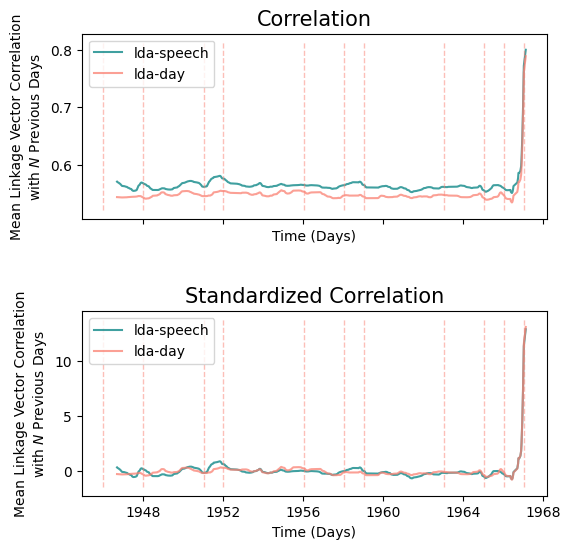

In [5]:
fig,ax = plt.subplots(2,1,figsize=(6,6),sharex=True)

for c,(model_type,agg_level) in enumerate(model_types):
    data = dataloader.load(cf,agg_level=agg_level,model_type=model_type)
    dists, labels, words = data['dists'],data['labels'],data['words']

    # Create a dictionary of day:theta, get stats forr daily theta's
    dict_date_theta = {d:_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('W'))}
    stats, mi_arrays = diachronic_linkage(dict_date_theta)

    # Flatten MI-matrices, use only lower triangle, create a DataFrame
    mi_arrays_flat = {k:flatten_mi_array(v) for k,v in tqdm(mi_arrays.items())}
    dfm = pd.DataFrame({k:v[2].to_numpy() for k,v in mi_arrays_flat.items()}).T

    # Create timestamps and matrix
    timestamps = dfm.index.to_numpy()
    theta = dfm.to_numpy()

    # Get Correlations
    cdf = diachronic_correlations_lookback(timestamps=timestamps,theta=theta,scale=14)
    cdf['c_afa'] = adaptive_filter(cdf['corr'].tolist(),span=100)
    ax[0].plot(cdf.date.dt.to_timestamp(),cdf.c_afa,color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)
    ax[1].plot(cdf.date.dt.to_timestamp(),zscore(cdf.c_afa),color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)


for a in [0,1]:
    ax[a].legend(loc='best')
    ax[a].set_xlabel('Time (Days)')
    ax[a].set_ylabel('Mean Linkage Vector Correlation')
    ax[a].set_title('Standardized Correlation' if a == 1 else 'Correlation',fontsize=15)
    add_cabinet_periods(ax[a],text=False)
    
plt.subplots_adjust(hspace=.5)
plt.savefig('figs/linkage-vector-correlation-diachronic-model_type-comparison.pdf',dpi=250,bbox_inches='tight')

plt.show()

In [4]:
cdf

,date,corr,c_afa
0,1947-05,0.547642,0.550377
1,1947-06,0.562803,0.551405
2,1947-07,0.565990,0.552433
3,1947-08,0.536728,0.553460
4,1947-09,0.551590,0.554488
...,...,...,...
199,1966-10,0.611594,0.639870
200,1966-11,0.618969,0.700499
201,1966-12,0.689390,0.749104
202,1967-01,0.741286,0.797709


100%|██████████| 218/218 [00:01<00:00, 168.64it/s]
/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/rb/Documents/GitHub/linkage/helpers/infodynamics.py:120: RuntimeWarning: invalid value encountered in subtract
  self.rsignal = self.nsignal - self.tsignal
/home/rb/Documents/GitHub/linkage/helpers/afa.py:186: RuntimeWarning: invalid value encountered in multiply
  xx_left = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)
/home/rb/Documents/GitHub/linkage/helpers/afa.py:191: RuntimeWarning: invalid value encountered in multiply
  xx_right = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)
/home/rb/Documents/GitHub/linkage/helpers/afa.py:235: RuntimeWarning: invalid value encountered in multiply
  xx_left = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)
/home/rb/Documents/GitHub/linkage/helpers/afa.py:301: RuntimeWarning: invalid value encountered in subtract


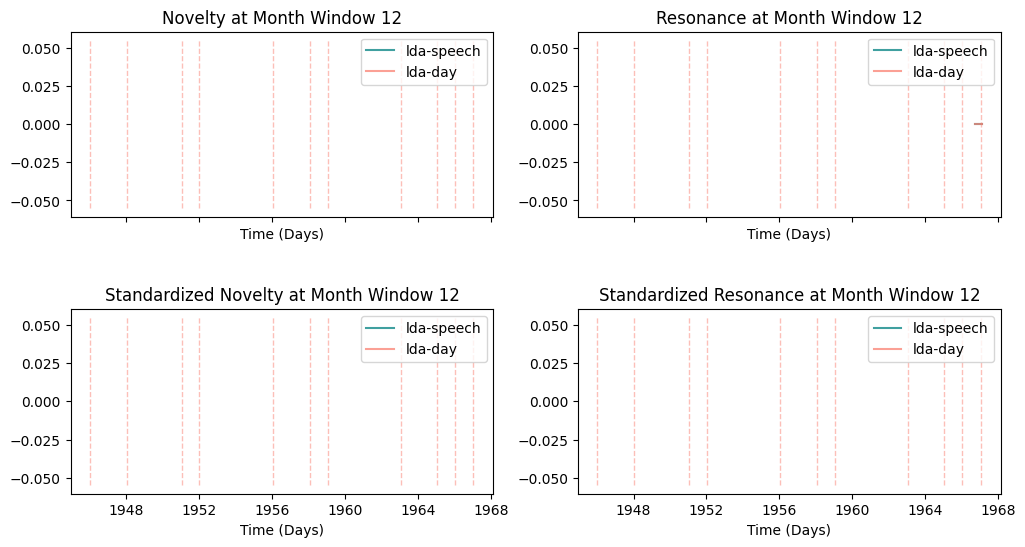

In [10]:
fig,ax = plt.subplots(2,2,figsize=(12,6),sharex=True)

for c,(model_type,agg_level) in enumerate(model_types):
    data = dataloader.load(cf,agg_level=agg_level,model_type=model_type)
    dists, labels, words = data['dists'],data['labels'],data['words']

    # Create a dictionary of day:theta, get stats forr daily theta's
    dict_date_theta = {d:_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('M'))}
    stats, mi_arrays = diachronic_linkage(dict_date_theta)

    # Flatten MI-matrices, use only lower triangle, create a DataFrame
    mi_arrays_flat = {k:flatten_mi_array(v) for k,v in tqdm(mi_arrays.items())}
    dfm = pd.DataFrame({k:v[2].to_numpy() for k,v in mi_arrays_flat.items()}).T

    # Create timestamps and matrix
    timestamps = dfm.index.to_numpy()
    theta = dfm.to_numpy()
    # theta = prob_dists(theta)

    # Novelty
    w = 12
    im = infodynamics.InfoDynamics(theta,timestamps,w)
    im = im.fit_return(meas=mc.jsd)
    imd = pd.DataFrame(im)
    imd['date'] = timestamps
    imd['n_afa'] = adaptive_filter(imd.novelty,span=100)
    imd['r_afa'] = adaptive_filter(imd.resonance,span=100)
    imd = imd.iloc[24:,:]
    
    ax[0,0].plot(imd.date.dt.to_timestamp(),imd.n_afa,color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)
    ax[1,0].plot(imd.date.dt.to_timestamp(),zscore(imd.n_afa),color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)

    ax[0,1].plot(imd.date.dt.to_timestamp(),imd.r_afa,color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)
    ax[1,1].plot(imd.date.dt.to_timestamp(),zscore(imd.r_afa),color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)

for a in ax.flatten():
    a.legend(loc='best')
    a.set_xlabel('Time (Days)')
    add_cabinet_periods(a,text=False)
    

ax[0,0].set_title('Novelty at Month Window 12')
ax[1,0].set_title('Standardized Novelty at Month Window 12')
ax[0,1].set_title('Resonance at Month Window 12')
ax[1,1].set_title('Standardized Resonance at Month Window 12')

plt.subplots_adjust(hspace=.5)
plt.savefig('figs/linkage-vector-novelty-resonance-diachronic-model_type-comparison.pdf',dpi=250,bbox_inches='tight')
plt.show()

In [5]:
# imd['n_afa_z'] = zscore(imd.n_afa)
# imd['r_afa_z'] = zscore(imd.r_afa)

In [6]:
# fig,ax = plt.subplots(1,1,figsize=(8,3))
# imd.plot(x='date',y=['n_afa_z','r_afa_z'],ax=ax)
# add_cabinet_periods(ax,alpha=1)
# ax.set_title('Comparison of Standardized Novelty (n) and Resonance (r) over Linkage Vectors\n Top2Vec - Speeches - Month-Level Linkage - Scale = 12')
# plt.savefig('figs/novelty-resonance-month-standardized-comparison-top2vec-old.pdf',dpi=250)
# plt.show()

AttributeError: 'DataFrameGroupBy' object has no attribute 'index'

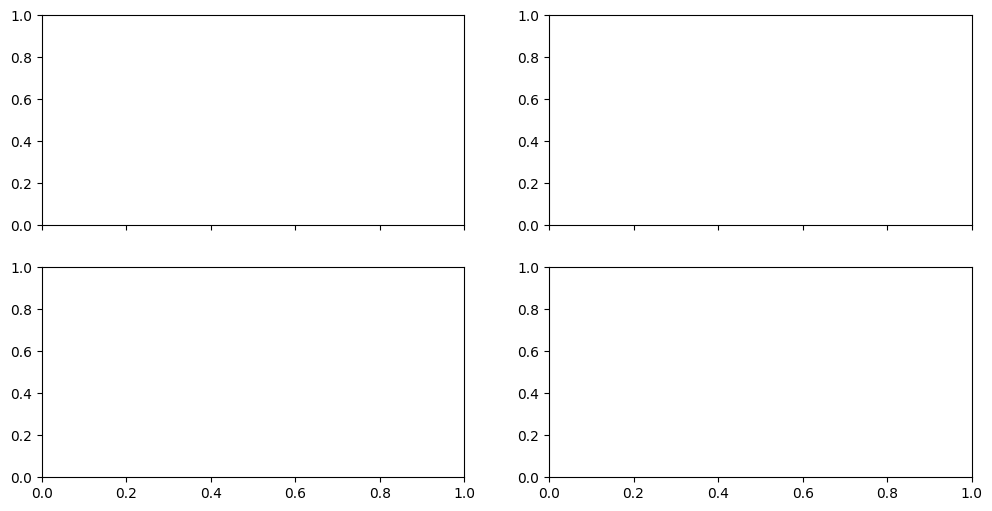

In [11]:
fig,ax = plt.subplots(2,2,figsize=(12,6),sharex=True)

for c,(model_type,agg_level) in enumerate(model_types):
    data = dataloader.load(cf,agg_level=agg_level,model_type=model_type)
    dists, labels, words = data['dists'],data['labels'],data['words']

    # Create a dictionary of day:theta, get stats forr daily theta's
    dists = dists.groupby(dists.index.to_period('M'))
    
    # Create timestamps and matrix
    timestamps = dists.index.to_numpy()
    theta = dists.to_numpy()
    # theta = prob_dists(theta)

    # Novelty
    w = 12
    im = infodynamics.InfoDynamics(theta,timestamps,w)
    im = im.fit_return(meas=mc.jsd)
    imd = pd.DataFrame(im)
    imd['date'] = timestamps
    imd['n_afa'] = adaptive_filter(imd.novelty,span=100)
    imd['r_afa'] = adaptive_filter(imd.resonance,span=100)
    imd = imd.iloc[24:,:]
    
    ax[0,0].plot(imd.date.dt.to_timestamp(),imd.n_afa,color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)
    ax[1,0].plot(imd.date.dt.to_timestamp(),zscore(imd.n_afa),color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)

    ax[0,1].plot(imd.date.dt.to_timestamp(),imd.r_afa,color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)
    ax[1,1].plot(imd.date.dt.to_timestamp(),zscore(imd.r_afa),color=colors[c],label=f'{model_type}-{agg_level}',alpha=.75)

for a in ax.flatten():
    a.legend(loc='best')
    a.set_xlabel('Time (Days)')
    add_cabinet_periods(a,text=False)
    

ax[0,0].set_title('Novelty at Month Window 12')
ax[1,0].set_title('Standardized Novelty at Month Window 12')
ax[0,1].set_title('Resonance at Month Window 12')
ax[1,1].set_title('Standardized Resonance at Month Window 12')

plt.subplots_adjust(hspace=.5)
plt.savefig('figs/linkage-vector-novelty-resonance-diachronic-model_type-comparison.pdf',dpi=250,bbox_inches='tight')
plt.show()